# Wprowdzenie

Dane importowane ze zbioru danych **"Pima Diabetes Dataset"** - powszechnie znanego i wielokrotnie poddawanego analizie oraz próbom tworzenia modelu klasyfikacyjnego, pobrany z portalu Kaggle. Oddany do publicznego użytku przez amerykański Narodowy Instytut Cukrzycy oraz Chorób Trawiennych i Nerek (National Institute of Diabetes and Digestive and Kidney Diseases) zbiór stanowi wyniki przeprowadzonych w 1965 roku niedaleko Phoenix w Arioznie badania wśród Indian z ludu Pima.

Źródło: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

Badane było występowanie cukrzycy typu 1 wśród kobiet w wieku 21 lat lub starszych wraz z czynnikami będącymi częstymi czynnikami przyczyniającymi się do wystąpienia cukrzycy lub jej symptomami. Oryginalnie zbiór danych zawiera 768 obserwacji dla 9 zmiennych:
*   **Outcome** - zmienna binarna przyjmująca wartość 1 gdy w ciągu 5 lat od rozpoczęcia badania u pacjenta stwierdzono cukrzycę; 0 w przeciwynm wpadku
*   **Age** - wiek kobiety w latach
*   **Pregancies** - liczba dotychczasowych ciąż
*   **Glucose** - poziom glukozy
*   **BloodPressure** - skurczowe ciśnienie krwi [mmHg]
*   **SkinThickness** - grubość fałdu skóry na tricepsie
*   **Insulin** - poziom insuliny we krwi 2 godziny po podaniu syropu glukozowego [mU/L - miliunits per liter]
*   **BMI** - Ineks Masy Ciała (Body Mass Index)
*   **DiabetesPedigreeFunction** - rodowodowa funkcja cukrzycy

Stworzony został model regresji logistycznej, gdzie zmienną prognozwoaną jest zmienna "Outcome", wybrane z pozostałych zmiennych mają w mają charakter zmiennych objaśniających.



# Importowanie danych

Dane importowane są z pliku csv, wyświetlane jest pierwszych kilka obserwacji oraz liczba obserwacji (wierszy) i zmiennych (kolumn) aby uppewnić się, że format oraz struktura danych są odpowiednie.

In [1]:
import pandas as pd

file_path = "diabetes.csv"
dataset = pd.read_csv(file_path)

print(dataset.head())

#Liczba wierszy i kolumn
rows, columns = dataset.shape

#Wyświetlenie liczby wierszy i kolumn
print(f"\nLiczba obserwacji: {rows}")
print(f"Liczba cech (kolumn): {columns}")


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Liczba obserwacji: 768
Liczba cech (kolumn): 9


# Analiza rozkładów zmiennych

W celu identyfikacji potencjalnych anomalii w danych przeprowadzona została graficzna analiza rozkładów poszczególnych zmiennych. Przedstawienie zmiennych numerycznych w formie histogramów pozwala na odczytanie częstości występowania wartości z poszczególnych przedziałów i porównanie ich z rozkładem którego należy się spodziewać po danym zjawisku.
Wykryte anomalie mogą często być spowodowane brakami lub błędnie wprowadzonymi danymi.

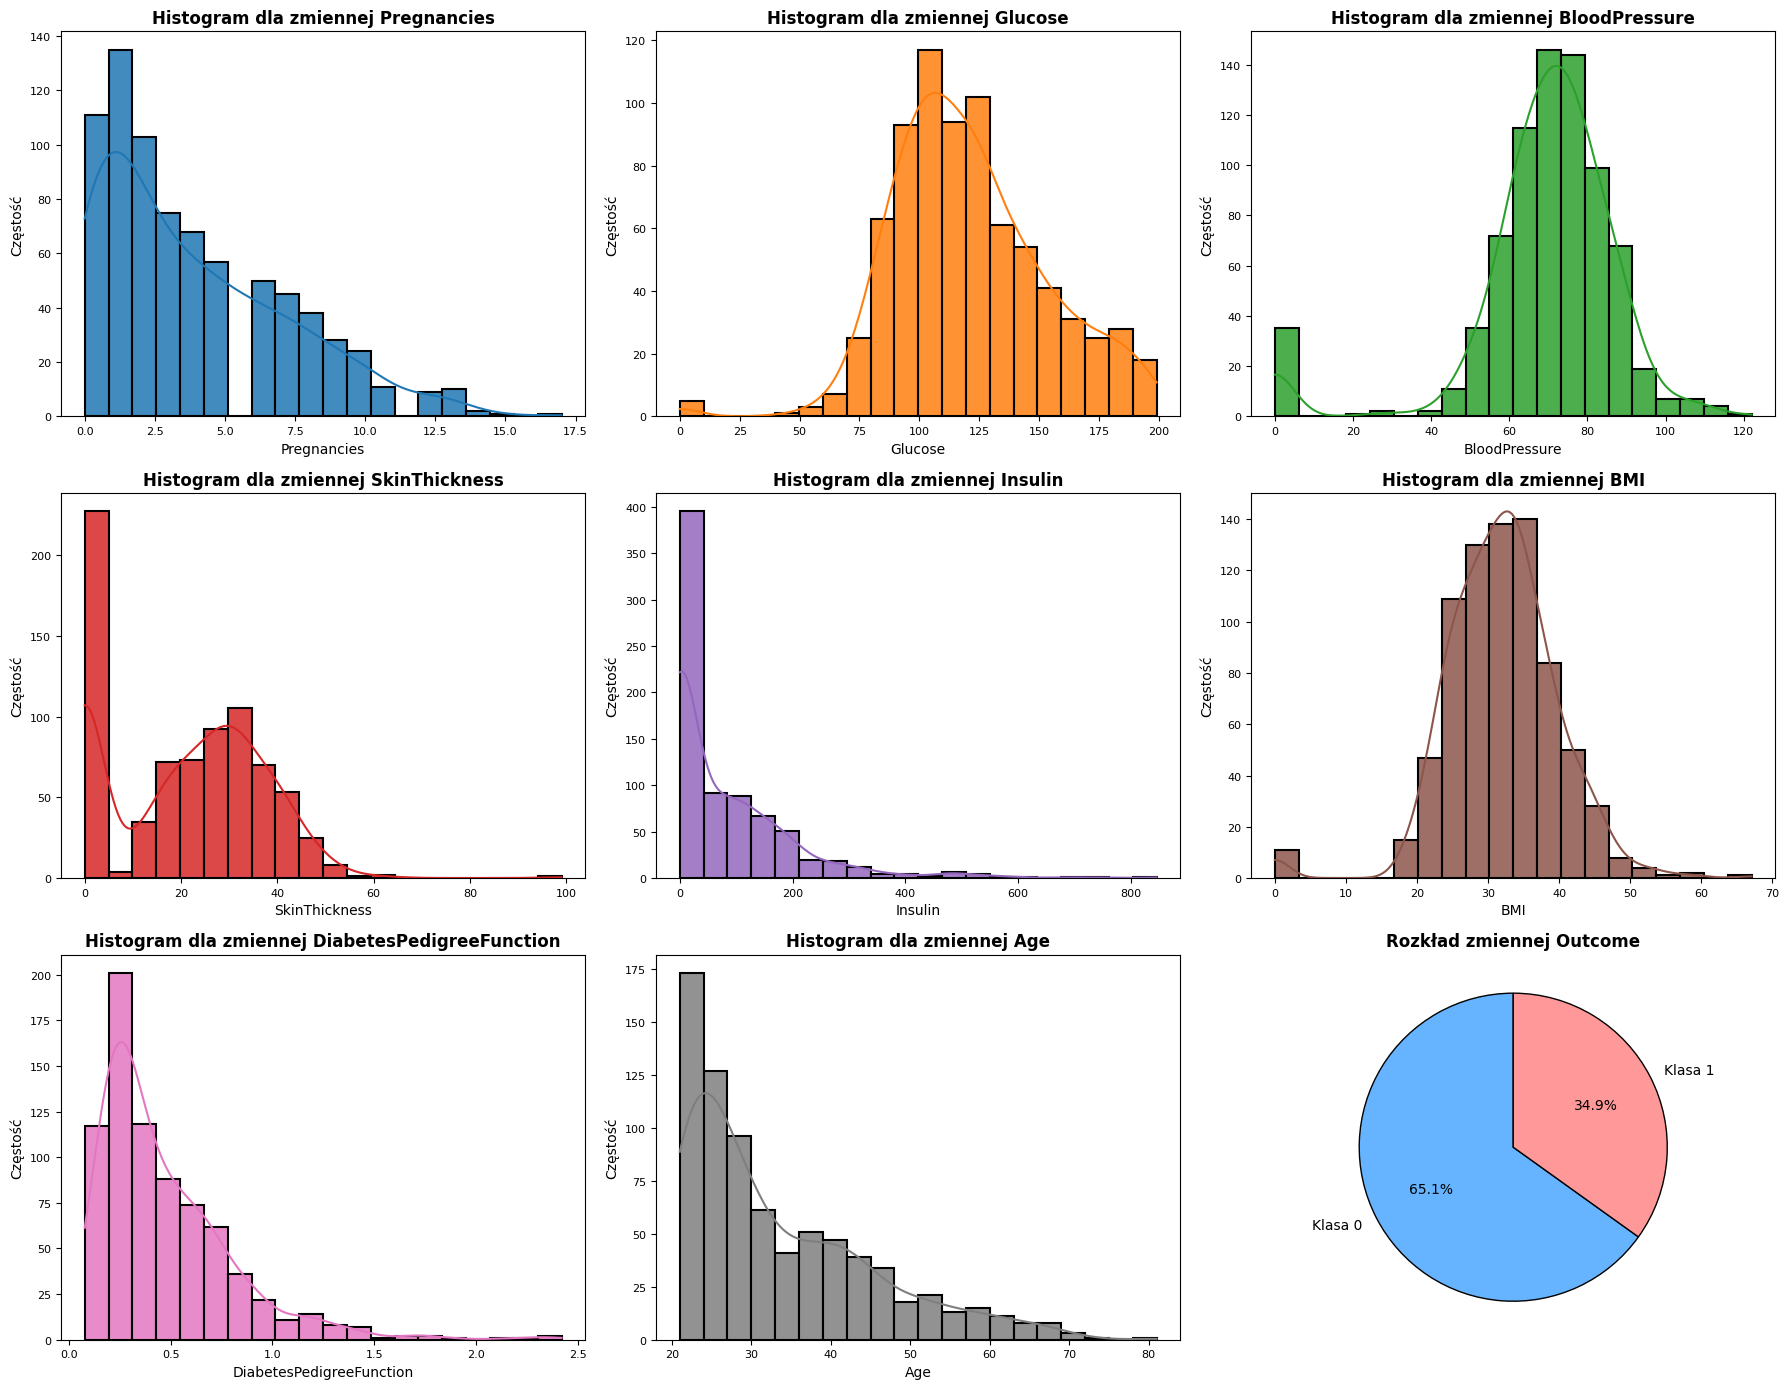

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#Histogramy dla zm numerycznych
numerical_columns = dataset.columns[:-1]

plt.figure(figsize=(18, 14))
color_palette = sns.color_palette("tab10", len(numerical_columns))

for i, (column, color) in enumerate(zip(numerical_columns, color_palette), 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[column], kde=True, bins=20, color=color, alpha=0.85, linewidth=1.5)
    plt.title(f"Histogram dla zmiennej {column}", fontsize=12, fontweight="bold")
    plt.xlabel(column, fontsize=10)
    plt.ylabel("Częstość", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

#Wykres kołowy zm Outcome
plt.subplot(3, 3, len(numerical_columns) + 1)
unique_classes, class_counts = dataset["Outcome"].value_counts().index, dataset["Outcome"].value_counts().values
plt.pie(class_counts, labels=[f"Klasa {cls}" for cls in unique_classes], autopct="%1.1f%%",
        startangle=90, colors=["#66b3ff", "#ff9999"], wedgeprops=dict(edgecolor="black", linewidth=1))
plt.title("Rozkład zmiennej Outcome", fontsize=12, fontweight="bold")

#Wyświetlanie
plt.tight_layout()
plt.show()


Jak widać wiele ze zmiennych ma zauważalny udział wartości zerowych. O ile w przypadku niektórych danych (jak np. liczba dotychczasowych ciąż lub poziomu insuliny u osób podejrzanych o występowanie cukrzycy) jest to spodziewane, o tyle w pzrypadku zmiennych reprezentujących BMI, ciśnienie krwi, poziom glukozy we krwi oraz grubość fałdu skóry jest to anomalia, najprawdopodobniej reprezentująca brakujące pomiary.

Pozostawienie tych obserwacji w zbiorze danych może prowadzić do pogorszenia jakości modelu, dlatego zmienna SkinThickenss zwaierająca ponad 200 brakującyh obserwacji wykluczona zostanie z dalszej budowy modelu, natomiast dla pozostałych zmiennych usunięte zostaną obserwacje z brakującymi wartościami.

Wykres kołowy zmiennej objaśnianej Outcome sugeruje, że z badanych pacjentów u ok. 35% wystąpiła cukrzyca typu pierwszego. Jest to wystarczający odsetek aby tworzyć wiarygodny model klasyfikacji binarnej.

# Usuwanie wartości odstających

Usunięta zostaje zmienna SkinThickness, oraz obserwacje przyjmujące wartości 0 dla zmiennych BMI, BloodPressure oraz Glucose.

In [3]:
#Usnięcie zmiennej SkinThickness
dataset = dataset.drop(columns=["SkinThickness"])

#Usunięcie zer w zm "Glucose", "BloodPressure", "BMI"
columns_to_clean = ["Glucose", "BloodPressure", "BMI"]
for column in columns_to_clean:
    zero_count = (dataset[column] == 0).sum()
    print(f"Liczba zerowych wartości w {column} przed czyszczeniem: {zero_count}")

#Tworzenie nowego dataframe bez zerowych wartości
dataset = dataset[(dataset["Glucose"] != 0) &
                          (dataset["BloodPressure"] != 0) &
                          (dataset["BMI"] != 0)]

#Nowa liczba wierszy i kolumn
rows, columns = dataset.shape

#Wyświetlenie
print(f"\nLiczba obserwacji: {rows}")
print(f"Liczba cech (kolumn): {columns}")

Liczba zerowych wartości w Glucose przed czyszczeniem: 5
Liczba zerowych wartości w BloodPressure przed czyszczeniem: 35
Liczba zerowych wartości w BMI przed czyszczeniem: 11

Liczba obserwacji: 724
Liczba cech (kolumn): 8


# Analiza rozkładów zmiennych po usunięciu obserwacji odstających

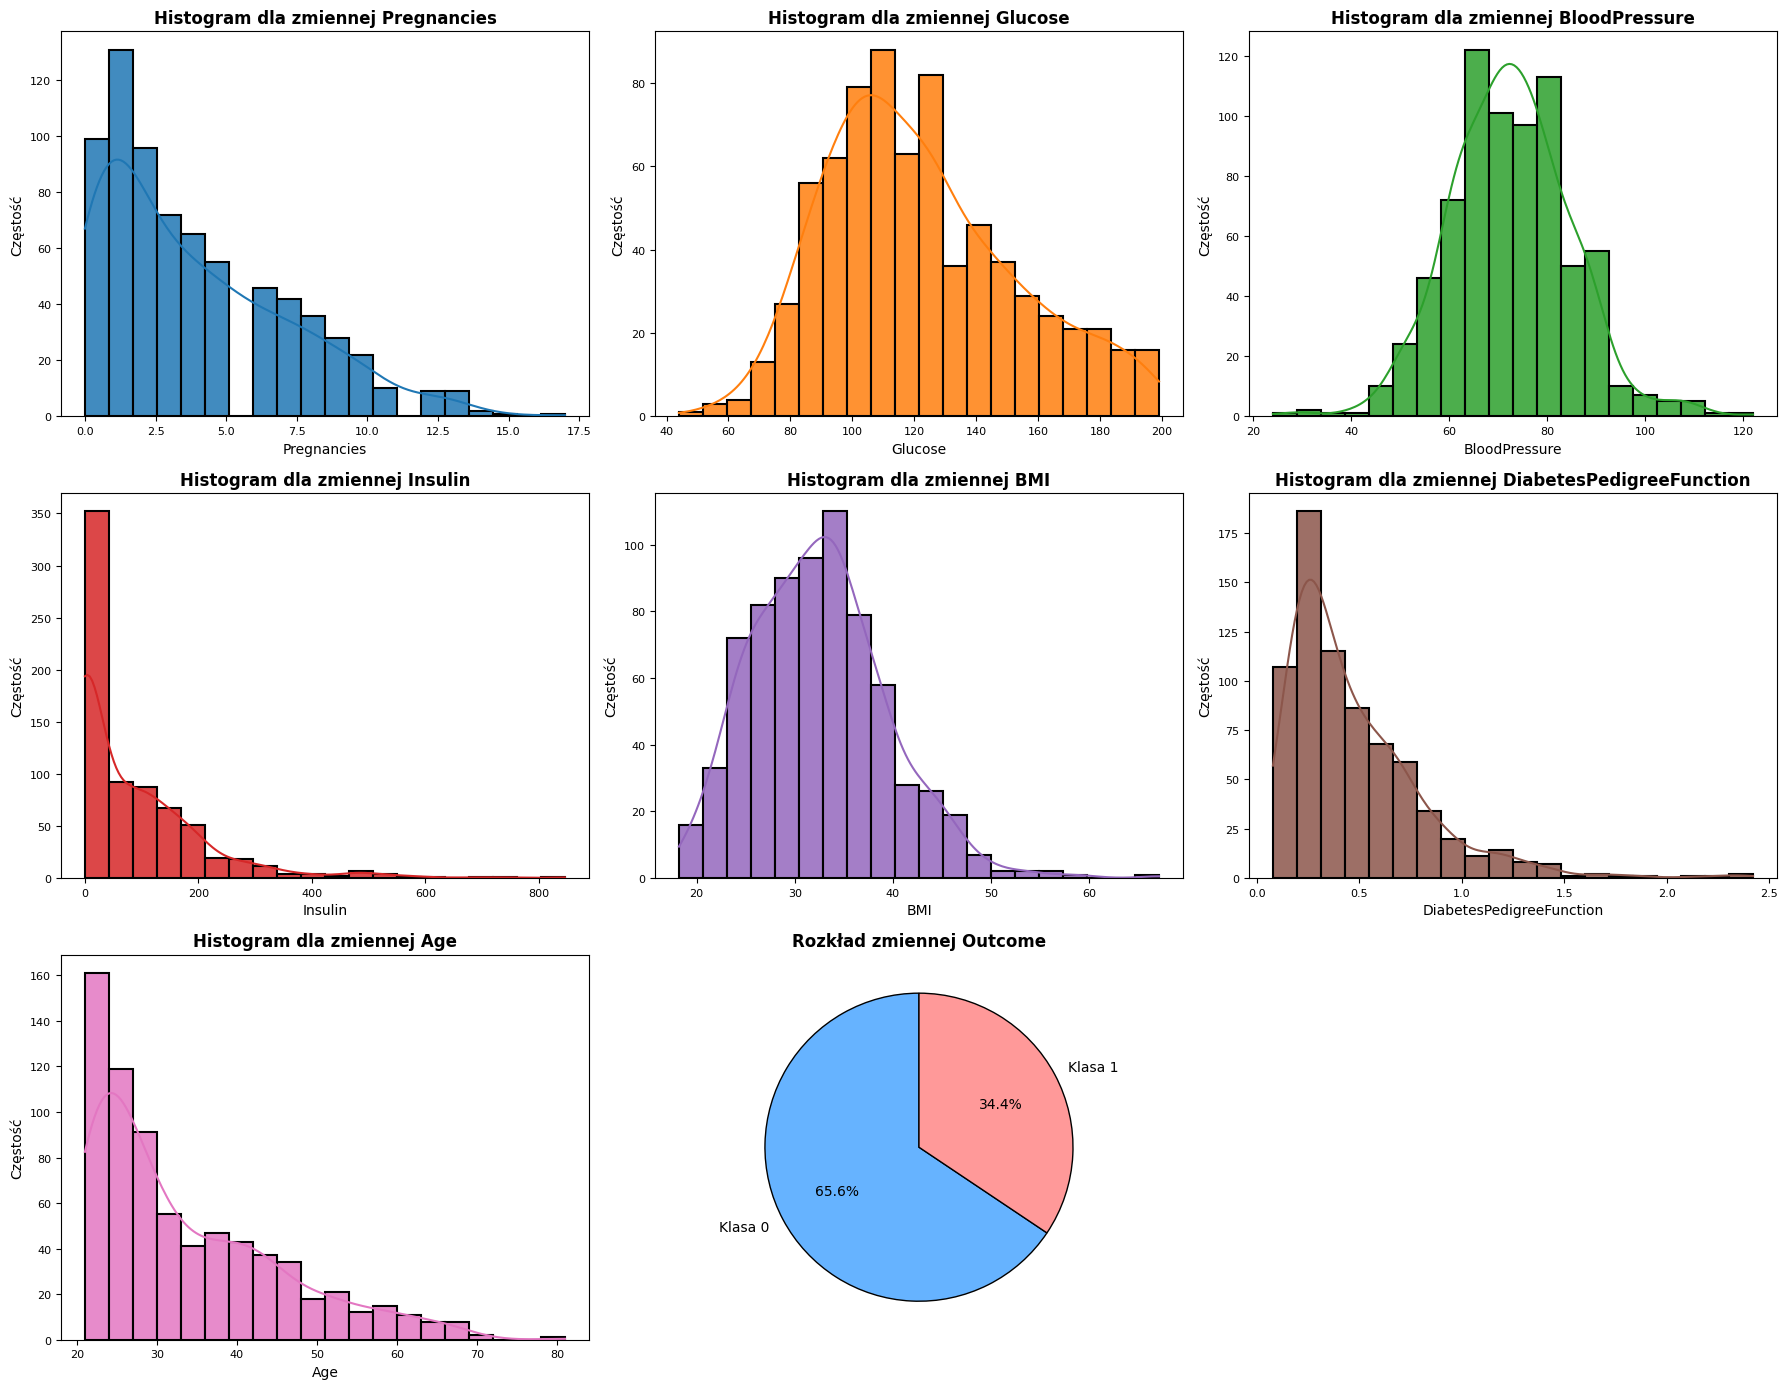

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#Nowe histogramy dla zmiennych numerycznych
numerical_columns = dataset.columns[:-1]

plt.figure(figsize=(18, 14))
color_palette = sns.color_palette("tab10", len(numerical_columns))

for i, (column, color) in enumerate(zip(numerical_columns, color_palette), 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[column], kde=True, bins=20, color=color, alpha=0.85, linewidth=1.5)
    plt.title(f"Histogram dla zmiennej {column}", fontsize=12, fontweight="bold")
    plt.xlabel(column, fontsize=10)
    plt.ylabel("Częstość", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

#Nowy wykres kołowy zm outcome
plt.subplot(3, 3, len(numerical_columns) + 1)
unique_classes, class_counts = dataset["Outcome"].value_counts().index, dataset["Outcome"].value_counts().values
plt.pie(class_counts, labels=[f"Klasa {cls}" for cls in unique_classes], autopct="%1.1f%%",
        startangle=90, colors=["#66b3ff", "#ff9999"], wedgeprops=dict(edgecolor="black", linewidth=1))
plt.title("Rozkład zmiennej Outcome", fontsize=12, fontweight="bold")

#Wyświetlenie
plt.tight_layout()
plt.show()


Ponowna analiza wykresów pozwala stwierdzić, że po usunięciu omówionych powyżej obserwacji rozkład niektórych zmiennych stał się bardziej symetryczny, a rozkłady przypominają takie, których można by spodziwać się w rzeczywistości.

# Macierz korelacji

Macierz korelacji pozwala w prosty sposób zwizualizować i odczytać siłę zależności (skorelowania) zmiennej objaśnianej ze zmiennymi obajśniającymi a także skorelowanie zmiennych objaśniających pomiędzy sobą. Najbardziej porządana jest sytuacja, w której zmienne objaśniające (predyktory) są mocno skorelowane ze mienną objaśnianą (targetem), a słabo skorelowane pomiędzy sobą - nie wnoszą do modelu wielokrotnie tych samych informacji.

Z racji, że zmienna objaśniania "Outcome" ma charakter binarny nie została ona umieszczona w macierzy korelacji, a zamiast tego obliczony dla niej został współczynnik korelacji punktowej-dwuseryjnej względem każdej ze zmiennych objaśniających, który bardziej rzetelnie niż współczynnik korelacji Pearsona oddaje stopień skorelowania zmiennej binarnej ze zmienną ciągłą.

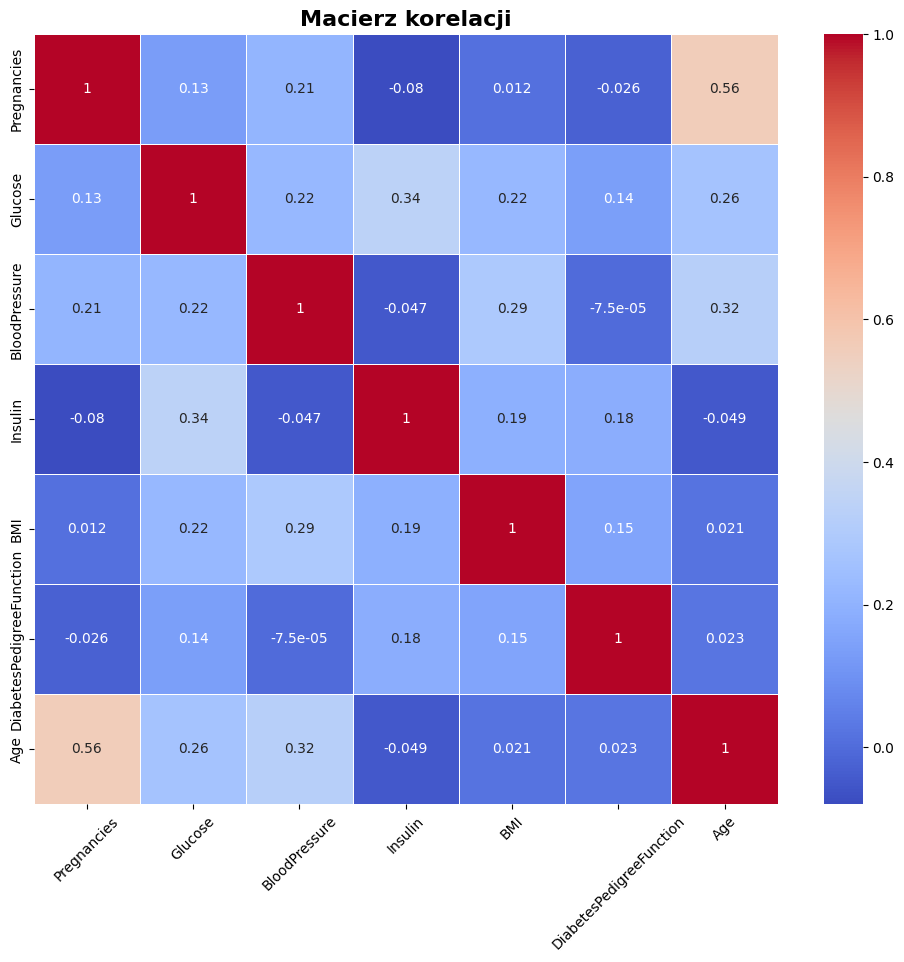

Zmienna                           Wsp. korelacji
                            punktowo-dwuseryjnej
------------------------  ----------------------
Pregnancies                             0.224417
Glucose                                 0.488384
BloodPressure                           0.166703
Insulin                                 0.145488
BMI                                     0.299375
DiabetesPedigreeFunction                0.184947
Age                                     0.245741


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from tabulate import tabulate

#Macierz korelacji zm zależnych
dataset_X = dataset.drop(columns=["Outcome"])
corr_matrix = dataset_X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Macierz korelacji", fontsize=16, fontweight="bold")
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

#Wsp point-biserial dla zm outcome
biser_corr = {}
for i in dataset.columns[:-1]:
  corr_coef = pointbiserialr(dataset[i], dataset["Outcome"])[0]
  biser_corr[i] = corr_coef

print(tabulate(list(biser_corr.items()), headers=["Zmienna", "Wsp. korelacji\npunktowo-dwuseryjnej"]))

Jak widać szczególnie niskim stopniem skorelowania ze zmienną Outcome wykazały się zmienne BloodPressure i Insulin. W kolejnych krokach mogą to być zmienne podejrzane o obniżanie jakości modelu.

Zmienne na ogół są między sobą słabo lub bardzo słabo skorelowane, z wyjątkiem zmiennych Age i Pregnancies, co jest spodziewane biorąc pod uwagę rzeczywistą naturę tych danych (liczba dotychczasowych ciąż może z wiekiem jedynie rosnąć).

# Sprawdzanie współczynników zmienności

Współczynniki zmienności zdefiniowany jako iloraz odchylenia standardowego i średniej obserwacji danej zmiennej jest miarą tego na ile zróżnicowane są wartości poszczególnych obserwacji owej zmiennej.

Przyjmuje się, że zmienne o zbyt małym zróżnicowaniu (wsp. zróżnicowania <=0,1) na ogół nie wnoszą wystarczającej ilości informacji do modelu.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import numpy as np

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

var_names = dataset.columns[:-1]

#Wsp korelacji
var_coefs = (np.std(X, axis=0, ddof=0)/np.mean(X, axis=0))
named_var_coefs = list(dict(zip(var_names, var_coefs)).items())
print(tabulate(named_var_coefs, headers=["Zmienna", "Wsp. zmienności"]))


Zmienna                     Wsp. zmienności
------------------------  -----------------
Pregnancies                        0.869234
Glucose                            0.252118
BloodPressure                      0.170873
Insulin                            1.38394
BMI                                0.212035
DiabetesPedigreeFunction           0.699473
Age                                0.352533


Wszystkie zmienne objaśniające wykazłu się stosunkowo wysokim współczynniekiem zmienności.

# Budowa modelu regresji logistycznej

Do zadania klasyfikacji danych wybrany został model regresji logistycznej powszechnie stosowany w zadaniach klasyfikacji binarnej zrówno w zadanicah ekonometrycznych jak i machine learningow"ych. WYrażona jest wzorem:

$P(Y_i = 1 \mid x_i ) = \frac{1}{(1 + exp (-x_i^Tβ))}$  
gdzie:   
$Y_i$ - zmienna zależna (tu: Outcome)   
$x_i$ - wektor wartości zmiennych objaśniających   
$\beta$ - parametry oszacowanego modelu

Funkcja LogisticRegression z paczki sklearn dopasowuje model poprzez iteracyjne zmienianie parametrów tak aby maksymalizować wartość logarytmu waiarygidniści - powszechni przyjętego kryterium szacowania paraemtrów wielu modeli ekonometrycznych, w tym regresji logistycznej. Przyjęto limit 500 iteracji.

Aby rzetelnie ocenić model i uniknąć zawyżania dokładności przez jego przeuczenie zbiór podzielony został na dane treningow i testowe, w proporcjach odpowiednio 80% i 20%. Dane testowe nie są brane pod uwagę podczas dopasowywania modelu, a jedynie przy prezentowaniu jedgo wyników.

Dane zostały odpowiednio ustandaryzowane aby względne wielkości zmiennych objaśnianych nie odgrywały roli przy ocenie parametrów, a także żeby możliwe było zastoswanie regularyzacji Ridge, chroniącej model przed przeuczeniem.

Jednak w przypadku zagadnienia przewidywania wystąpienia cukrzycy najważniejsza nie jest ogólna dokładność modelu ani wysoka wartość funkcji wiarygodności, ale zdolność modelu do wyłapania jak największego odsetka osób, u których faktycznie może wystąpić cukrzyca na czas. Dlatego najważniajszą statystyką modelu, którą należy wziąć pod uwagę jest czułość (ang. sensitivity) zdefiniowana jako odsetek obserwacji pozytywnych poprawnie zaklasyfikowanych przez model.

Aby mieć możliwość większej kontroli nad modelem i różnymi osiąganymi przez niego metrykami dopasowania (w tym wspomnianą wyżej czułością), a także skompensować nierónomierny rozkład wartości pozytywanych (1) i negatywnych (0) zmiennej Outcome przydzielono im wagi, odpowiednio 1 i 2 - układ taki pozwala na uzyskanie większej czułości modelu.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
import numpy as np

#Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standaryzacja
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Tworzenie modelu
model = LogisticRegression(max_iter=500, class_weight={0: 1, 1: 2})
model.fit(X_train, y_train.ravel())

#Oszacowany model
model_coefs = dict(zip(var_names, model.coef_[0]))
model_coefs["Przecięcie"] = model.intercept_[0]

print(tabulate(list(model_coefs.items()), headers = ["Zmienna", "Wartość współczynnika\nw modelu"]))

#Ocena modelu na zbiorze treningowym
y_pred_train = model.predict(X_train)
print()
print("WYNIKI MODELU (dane treningowe)")
print("Dokładność modelu:", accuracy_score(y_train, y_pred_train))
print("\nRaport klasyfikacji:\n", classification_report(y_train, y_pred_train))



Zmienna                     Wartość współczynnika
                                         w modelu
------------------------  -----------------------
Pregnancies                              0.467571
Glucose                                  1.15433
BloodPressure                           -0.149329
Insulin                                 -0.102867
BMI                                      0.74357
DiabetesPedigreeFunction                 0.41629
Age                                      0.197051
Przecięcie                              -0.143183

WYNIKI MODELU (dane treningowe)
Dokładność modelu: 0.7582037996545768

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80       373
           1       0.63      0.77      0.69       206

    accuracy                           0.76       579
   macro avg       0.74      0.76      0.75       579
weighted avg       0.78      0.76      0.76       579



Dla dobranych manualnie wag na zbiorze treningowym udało się osiągnąć czułość (nazwaną na powyższym podsumowaiu "recall") dla pozytywnych obserwacji na poziomie 77%, co stanowi relatywnie wysoki poziom czułości.
Analogiczna statystyka dla wartości negatywnych wynosiła 73%.

Ponadto dopasowany model jest w stanie osiągnąć niemal 76% dokładność - 76% wszystkich obserwacji jest poprawnie klasyfikowanych.

Precyzja dla 0 i 1 jest miarą tego jaki odsetek obserwacji zaklasyfikowanych przez model do danej kategorii w zreczywistości do niej należał, w tym przypadku precyzja dla wartości 1 wynosząca 62% oznacza, że 62% obserwacji zaklasyfikowanych przezmodel jako przypadki wystąpienia cukrzycy pokrywały się z rzecywistością. Analogiczna miara dla obserwacji negatywnych wyniosła 86%.


Niestety ze względu na konieczność normalizacji danych przed dopasowaniem modelu nie da się jednoznacznie zinterpretować wartości odpowiadjących im oszacowanych wspołczynników $\beta$. Jednach ich wartość informuje o tym na ile istotny jest dany parametr w modelu.
Widać zatem, że przy klasyfikacji największe znaczenie mają wartości zmiennych Glucose oraz Pregnancies, a najmniejsze - Blood Pressure oraz Insulin. Parametry przy tych dwóch ostatnich zmiennych jako jedyne, poza wyrazem wolnym, mają wartości ujemne - oznacza to, że są jedynymi zmiennymi, których wzrost wartości wpływać może na zmniejszenie ryzyka cukrzycy. W przypadku pozostałych zmiennych duże wartości wiążą się z większym prawdopodobieństwe wystąpienia choroby.

#Ocena jakości mocelu

W celu sprawdzenia jak model radzi sobie z nowymi danymi, do których nie był dopasowywany, ocenę jakości wykonano również na danych wydzielonych wcześniej jako zbiór testowy. Spadek jakości względem wyników uzyskanych na danyc treningowych oznaczać może wystąpienie przeuczenia - dopasowanie się modelu do bardzo specyficznych zależności w danych występujących jedynie w zbiorze treningowym. Czyniło by to model nieużytecznym w przyjętym zadaniu prognostycznym.

In [8]:
y_pred_test = model.predict(X_test)

# Ocena modelu
print("OCENA JAKOŚCI MODELU (dane testowe)")
print("Dokładność modelu:", accuracy_score(y_test, y_pred_test))
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred_test))


OCENA JAKOŚCI MODELU (dane testowe)
Dokładność modelu: 0.7448275862068966

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80       102
           1       0.55      0.74      0.63        43

    accuracy                           0.74       145
   macro avg       0.71      0.74      0.72       145
weighted avg       0.78      0.74      0.75       145



Jak widać dla danych testowych model wykazał się nieco większą ogólną dokładnością klasyfikacji na poziomie ok. 74,5%.

Nieco niższa okazała się również czułość dla pozytywnych przypadków cukrzycy - 74% (3 pkt.% spadku względem wyników na danych treningowych).

Niestety próba klasyfikacji danych testowych wykazała się też niską precyzją dla pozytywnych obserwacji - u niwielu ponad połowy z pacjentów dla których model faktycznie wskazał cukrzycę faktycznie ona wsytępowała.

# Macierz pomyłek

Macierz pomyłek dla zmiennych 2-wartościowych stanowi proste przedstawienie tego jak klasyfikowane były zmienne z danych kategorii przez model.

Poniżej stworzono macierz pomyłek dla predykcji wykonanych przez model dla zbioru testowego. Rzędy reprezentują rzeczywiste wartości zmiennej (0 oraz 1) a kolumny predykcje (również 0 i 1). Na ich przecięciach wpisane są liczby rozpatrywanych obserwacji, dla ktoryh wartość rzeczwista i predykcja przyjęły dane wartości.

Wartość w komórce "1-1" (liczba obserwacji będących pozytwnymi zarówno w klasyfikacji jak i w rzeczywistości) to tzw. TP - ang. True Positves.
Wartość z komórki "0-0" to TN, czyli ang. True Negatives.
Pozostałe obserwacje zaloczają się do fałszywych pozytywó (ang. False Positives) lub fałszywych negatywów (ang. False Negatives).

Informacje zawarte w macierzy pomyłek stanowią podstawę do wyliczania wielu ze wskaźników jakości modelu, w tym wspomnianych wyżej dokładności, precyzji i czułości.

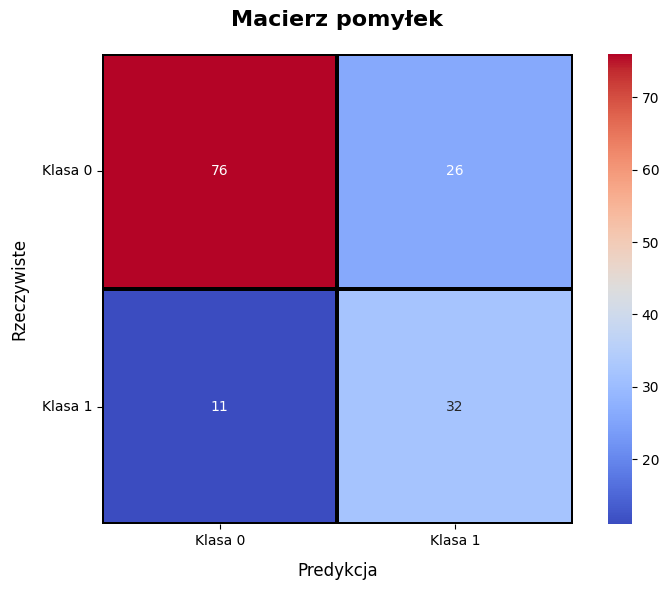

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred_test)

#Wizualizacja
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True,
            linewidths=1.5, linecolor="black", square=True,
            xticklabels=["Klasa 0", "Klasa 1"],
            yticklabels=["Klasa 0", "Klasa 1"])
plt.title("Macierz pomyłek", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Predykcja", fontsize=12, labelpad=10)
plt.ylabel("Rzeczywiste", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# Wykres krzywej ROC

Krzywa ROC (Receiver Operating Curve) ilustruje jak dla wybranego modelu zmienia się True Positive Rate TPR (odsetek poprawnie zaklasyfikowanych obserwacji pozytywnych w zbiorze danych) wraz ze wzrostem False Positive Rate FPR (odsetka obserwacji negatywnych zaklasyfikowanych jako pozytywne). Odpowiadające sbie wartości TPN i FPN uzyskuje się poprzez obliczanie ich wartości dla danego progu klasyfikacji, gdzie próg oznacza minimalną wartość prawdopodobieństwa zwróconego przez model koniecznego by zaklasyfikować obserwację jako pozytywną.

Owe punkty naniesione na wykres gdzie poziomą oś stanowią wartości FPR, a pionową - TPR tworzą krzywą ROC. Model dobrej jakości jest w stanie poprawnie klasyfikować pozytywne obseracje (a zatem osiągać wysokie TPR) jednocześnie klasyfikując mało negatywnych obserwacji jako pozytywne (czyli osiągać małe FPR). Stąd porządana jest sytuacja, w której wartość TPR wzrasta szybko dla stosunkowo niewielkich wartości FPR.

Jeśli model model wykazuje się taką własnością, wówczas pole wykresu pod krzywą ROC rośnie dążąc do wartości 1. Wartość pola pod wykresem nazywana jest AUC i podawana jest jako jedna z metryk służąca do oceny jakości modelu - preferowane są wysokie wartości.


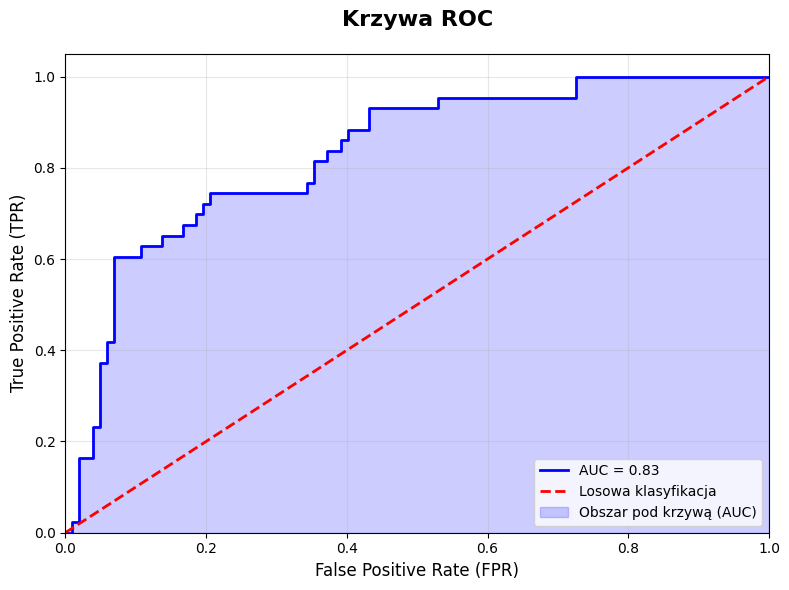

In [10]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#Wykres ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=2, label="Losowa klasyfikacja")
plt.fill_between(fpr, tpr, alpha=0.2, color="blue", label="Obszar pod krzywą (AUC)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Krzywa ROC", fontsize=16, fontweight="bold", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Jak widać na powyższym wykresie dla bliskim zera wartościom False Positive Rate toważysz szybki spadek True Positive Rate (TPR równe ok. 0,6 osiągane jest dla FPR mniejszego niż 0,1).

Wartość AUC wyniosła 0,83 co świadczy, że model jest o wiele lepszy od klasyfikacji losowej - czyli sprawdza się.